In [1]:
%load_ext autoreload
%autoreload 2

# DCR Extension Tutorial

This file will give a walkthrough of the extension that has been made for the PM4Py library.
Namely, it will go through how to create a DCR Graph,  either manually or automatically by the implemented DisCoveR algorithm, showcase how conformance checking can be used to determine fitness, and finally present the import/export capability such that the graph can be visualised.


## Creating DCR Graphs
First, let's take a look at how to create a basic DCR Graph manually. Note that the underlying attribute in the DCR graph objects consists of sets and dictionaries, so one can access them through the property, and call them as such:

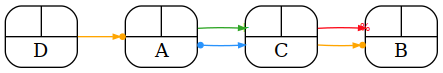

In [2]:
import pandas as pd

import pm4py
from pm4py.objects.dcr.obj import DcrGraph
graph = DcrGraph()
graph.events.add("activity1")
graph.events.add("activity2")
graph.events.add("activity3")
graph.events.add("activity4")
graph.labels.add("A")
graph.labels.add("B")
graph.labels.add("C")
graph.labels.add("D")
graph.label_map["activity1"] = "A"
graph.label_map["activity2"] = "B"
graph.label_map["activity3"] = "C"
graph.label_map["activity4"] = "D"
graph.conditions["activity1"] = {"activity2"}
graph.conditions["activity2"] = {"activity3"}
graph.responses["activity1"] = {"activity3"}
graph.excludes["activity3"] = {"activity2"}
graph.conditions["activity1"] = {"activity4"}
graph.includes["activity1"] = {"activity3"}
graph.marking.included.add("activity1")
graph.marking.included.add("activity2")
graph.marking.included.add("activity3")
graph.marking.included.add("activity4")
pm4py.view_dcr(graph)

When the graph has been constructed, one has access to the following commands to get the different properties of the DCR graph, such as the size defined by the number of constraints, the events associated with the activity or vice versa.

In [3]:
print(graph.get_constraints())
print(graph.get_activity("activity1"))
print(graph.get_event("A"))
del graph

5
A
activity1


If one calls get_event() or get_activity() with a value that doesn't exist, it will return the input value. This was implemented for the conformance checking, since if someone tries to get the labelMapping but the event doesn't exist, the test would be interrupted. This way, if it doesn't exist, it will be noted by the conformance tools and be used in the conformance result.

Now to discover a model with a given input log, a simplified interface has been created, such that the implemented algorithms are easily accessible, and therefore allow for a more simplified and straightforward use.

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

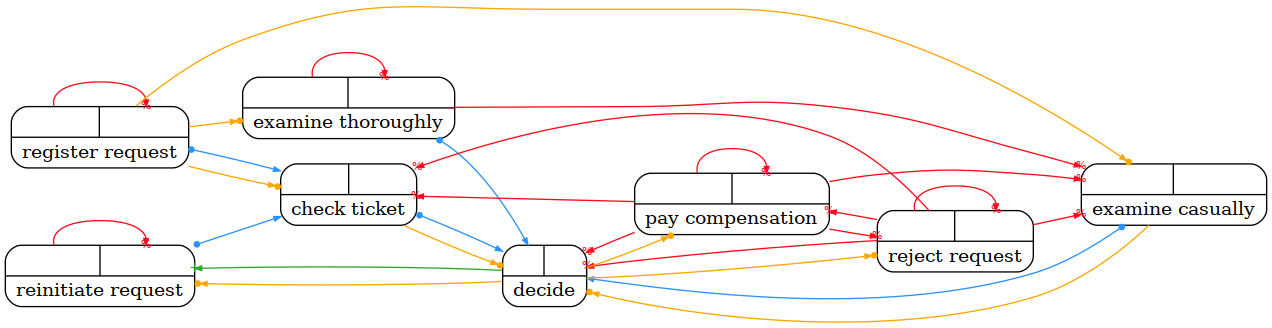

In [4]:
import pm4py
log = pm4py.read_xes("../tests/input_data/running-example.xes")
graph, _ = pm4py.discover_dcr(log)  
pm4py.view_dcr(graph)   
del graph

In accordance to the rest of the library, the simplified interface takes in extra values for which one can use to specify the naming convention in the attribute, such that it can mine the log without failure.

Additionally, the discover miner has been extended to allow for mining of roles; we will use the log of the running example once again.

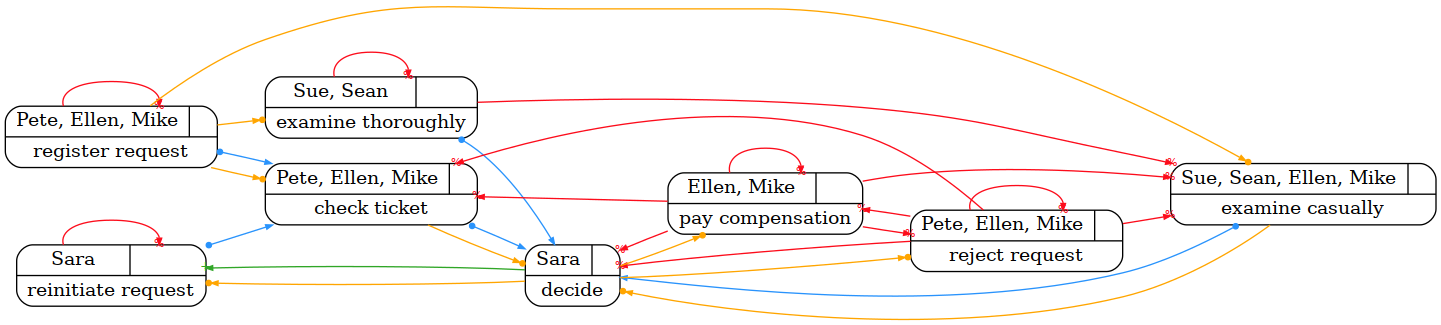

In [5]:
graph, _ = pm4py.discover_dcr(log,post_process={"roles"},group_key="org:resource")
pm4py.view_dcr(graph)
del graph

If one doesn't wish to use the simplified interface, there is a more indirect way of performing the process mining technique

In [6]:
from pm4py.algo.discovery.dcr_discover.variants.dcr_discover import Discover
from pm4py.objects.dcr.obj import DcrGraph
disc = Discover()
graph = DcrGraph(disc.mine(log)[0])
del log
del graph

Note that the discover miner also returns the abstraction log used for mining the DCR Graph, therefore it is needed to perform to specify the first iterative of the tuple.

## Conformance Checking
Two different techniques for checking conformance of a DCR graph have been implemented
### Rule Checking
The first technique is a quite straight forward approach. It takes an event log, and mines based on the constraints within the graph. This technique takes in a whole log and produces an output: a list of dictionaries of the values associated with the mining:

In [7]:
log = pm4py.read_xes("../tests/input_data/running-example.xes")
graph, _ = pm4py.discover_dcr(log)
conf_res = pm4py.conformance_dcr(log, graph, return_diagnostics_dataframe=True)
conf_res

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

,case_id,no_dev_total,no_constr_total,dev_fitness
0,3,0,28,1.0
1,2,0,28,1.0
2,1,0,28,1.0
3,6,0,28,1.0
4,5,0,28,1.0
5,4,0,28,1.0


Due to the DisCoveR miner's property of always producing a graph with perfect fitness, the output will therefore have no deviations. In addition to mining of DCR graphs, it is also possible to check for deviations in role assignment.

In [8]:
# Given an event log and discovering a dcr
log = pm4py.read_xes("../tests/input_data/running-example.xes")
graph, _ = pm4py.discover_dcr(log, post_process={'roles'}, group_key="org:resource")

# when the roles are changed and conformance is performed
log = log.replace("Mike", "Brenda")
conf_res = pm4py.conformance_dcr(log, graph, group_key="org:resource", return_diagnostics_dataframe=True)
conf_res

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

,case_id,no_dev_total,no_constr_total,dev_fitness
0,3,1,47,0.978723
1,2,1,47,0.978723
2,1,1,47,0.978723
3,6,1,47,0.978723
4,5,1,47,0.978723
5,4,1,47,0.978723


Just like in the previous example, one can call the underlying algorithm directly if they wish to do so. In this case, one can call the class used for conformance checking:

In [9]:
from pm4py.algo.conformance.dcr.variants.classic import RuleBasedConformance
parameters = pm4py.utils.get_properties(log,group_key="org:resource")
rulecheck = RuleBasedConformance(log, graph,parameters)
conf_res = rulecheck.apply_conformance()
pd.DataFrame(conf_res)

,no_constr_total,deviations,no_dev_total,dev_fitness,is_fit
0,47,"[(roleViolation, Brenda)]",1,0.978723,False
1,47,"[(roleViolation, Brenda)]",1,0.978723,False
2,47,"[(roleViolation, Brenda)]",1,0.978723,False
3,47,"[(roleViolation, Brenda)]",1,0.978723,False
4,47,"[(roleViolation, Brenda)]",1,0.978723,False
5,47,"[(roleViolation, Brenda)]",1,0.978723,False


### Alignment

The extension also allows for determining the optimal alignment of a DCR Graph.

In [10]:
log = pm4py.read_xes("../tests/input_data/running-example.xes")
graph, _ = pm4py.discover_dcr(log)
align_res = pm4py.optimal_alignment_dcr(log, graph)
align_res

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

[{'alignment': [('register request', 'register request'),
   ('examine thoroughly', 'examine thoroughly'),
   ('check ticket', 'check ticket'),
   ('decide', 'decide'),
   ('reject request', 'reject request')],
  'cost': 0,
  'visited_states': 7,
  'closed': 6,
  'global_min': 0,
  'fitness': 1.0,
  'bwc': 5},
 {'alignment': [('register request', 'register request'),
   ('check ticket', 'check ticket'),
   ('examine casually', 'examine casually'),
   ('decide', 'decide'),
   ('pay compensation', 'pay compensation')],
  'cost': 0,
  'visited_states': 8,
  'closed': 6,
  'global_min': 0,
  'fitness': 1.0,
  'bwc': 5},
 {'alignment': [('register request', 'register request'),
   ('examine casually', 'examine casually'),
   ('check ticket', 'check ticket'),
   ('decide', 'decide'),
   ('reinitiate request', 'reinitiate request'),
   ('examine thoroughly', 'examine thoroughly'),
   ('check ticket', 'check ticket'),
   ('decide', 'decide'),
   ('pay compensation', 'pay compensation')],
  'co

This can be viewed as a DataFrame:

In [11]:
align_res = pm4py.optimal_alignment_dcr(log, graph, return_diagnostics_dataframe=True)
align_res

,case_id,cost,fitness,is_fit
0,3,0,1.0,True
1,2,0,1.0,True
2,1,0,1.0,True
3,6,0,1.0,True
4,5,0,1.0,True
5,4,0,1.0,True


## Importing/Exporting DCR Graphs
We can visualise the mined DCR graph in third party applications by exporting it as an 'xml' file and then viewing it at the corresponding portal.

In [89]:
import pm4py
from pm4py.objects.dcr.exporter import exporter as dcr_exporter
log = pm4py.read_xes("../tests/input_data/running-example.xes")
graph, _ = pm4py.discover_dcr(log)
path = '../tests/test_output_data/dcrgraph.xml'
pm4py.write_dcr_xml(graph, path, variant=dcr_exporter.XML_SIMPLE, dcr_title='dcrgraph', replace_whitespace=' ')

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

In this case, we can visualise the graph at the following link: https://hugoalopez-dtu.github.io/dcr-js/.

Importing the graph is just as easy.

In [90]:
from pm4py.objects.dcr.importer import importer as dcr_importer
graph = pm4py.read_dcr_xml(path, variant=dcr_importer.XML_SIMPLE)
# pm4py.view_dcr(graph)

In [91]:
graph

events: {'reinitiate request', 'register request', 'examine thoroughly', 'check ticket', 'reject request', 'examine casually', 'pay compensation', 'decide'}
marking: {executed: set(), included: {'reinitiate request', 'register request', 'examine thoroughly', 'check ticket', 'reject request', 'examine casually', 'pay compensation', 'decide'}, pending: set()}
labels: {'reinitiate request', 'register request', 'examine thoroughly', 'check ticket', 'reject request', 'examine casually', 'pay compensation', 'decide'}
conditionsFor: {'reinitiate request': {'decide'}, 'examine thoroughly': {'register request'}, 'check ticket': {'register request'}, 'reject request': {'decide'}, 'examine casually': {'register request'}, 'pay compensation': {'decide'}, 'decide': {'examine casually', 'check ticket'}}
responseTo: {'reinitiate request': {'check ticket'}, 'register request': {'check ticket'}, 'examine thoroughly': {'decide'}, 'check ticket': {'decide'}, 'examine casually': {'decide'}}
includesTo: {'

One can alter the graph using the DCR-js tool and then import it back into PM4Py for further manipulation, for instance checking the alignment of the new model.

In [13]:
path_edited = '../tests/test_output_data/dcrgraph_edited.xml'
graph_edited = pm4py.read_dcr_xml(path_edited, variant=dcr_importer.DCR_JS_PORTAL)
# pm4py.view_dcr(graph_edited)          
align_res = pm4py.optimal_alignment_dcr(log, graph_edited, return_diagnostics_dataframe=True)
align_res

Exception: File does not exist

In [18]:
# cleanup
import os
os.remove(path)
os.remove(path_edited)

FileNotFoundError: [Errno 2] No such file or directory: '../tests/test_output_data/dcrgraph.xml'